In [1]:
import requests
import re
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import highlight_text as htext
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.font_manager
from PIL import Image
from io import BytesIO
from sklearn.cluster import KMeans
import khelper.funcs as kh

In [2]:
# SET SEASON, WEEK, TEAM to be plotted
SEASONS = [2022]
WEEKS = [2]
TEAMS = ['SF','KC']

In [3]:
# get team info (colors, URLS, abbr., etc.)
df_teams_info = pd.read_csv("./data/team_logos.csv")

# get pbp_participation
par = []
for SEASON in SEASONS:
    par.append(pd.read_csv(f"https://github.com/nflverse/nflverse-data/releases/download/pbp_participation/pbp_participation_{SEASON}.csv"))
df_par = pd.concat(par)
del par

# get play by play for season
cols = ['game_id',
        'play_id',
        'epa',
        'season_type',
        'season','week',
        'drive','series',
        'down',
        'ydstogo',
        'yards_gained',
        'wp',
        'ep',
        'yardline_100',
        'home_team',
        'away_team',
        'posteam',
        'defteam',
        'game_seconds_remaining',
        'game_half',
        'fixed_drive_result',
        'play_type',
        'penalty_team',
        'penalty_type',
        'penalty_yards'] #'qb_kneel','field_goal_attempt','TD_team','safety','penalty','fumble_lost','interception','fourth_down_failed']

df_pbp = nfl.import_pbp_data(years=SEASONS, columns=cols, downcast=True, cache=False)
ALL_TEAMS = df_pbp.posteam.dropna().unique().tolist()
ALL_WEEKS = df_pbp.week.dropna().unique().tolist()

2022 done.
Downcasting floats.


In [4]:
# FONT FAMILY
# add font family
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-light.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-bold.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-black.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-roman.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Bebas_Neue/BebasNeue-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Bangers/Bangers-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Contrail_One/ContrailOne-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Goldman/Goldman-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Goldman/Goldman-Bold.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Permanent_Marker/PermanentMarker-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Righteous/Righteous-Regular.ttf')
# assign name of font family
azkidenz_text = "AkzidenzGrotesk"
bebas_text =  "Bebas Neue"
loma_text = "Loma"
bangers_text = "Bangers"
contrail_text = "Contrail One"
goldman_text = "Goldman"
pm_text = "Permanent Marker"
righteous_text = "Righteous"
ubuntuc_text = "Ubuntu Condensed"
padaukb_text = "Padauk Book"

# ASSIGN FONT FAMILY TO PLOT'S TEXT
title_text = bebas_text
subtitle_text = padaukb_text #ubuntuc_text
axs_label_text = contrail_text
axs_title_text = bebas_text
touchdown_text = bangers_text
drive_result_text = contrail_text
credits_text = goldman_text


# ALTERNATIVE COLOR
background ="#efefef"#"#DBDBDB" #"#808B96" straw"#e0dfd5"
text_color = "black"
title_color = "#706f6f"
axs_title_color = "black"#"#ff1d15" #"#706f6f"#"#DB3a34"#"#7cc6fe"#"#7cc6fe"
axs_title2_color = "#706f6f"
axs_label_color = "black"#"#FFC53A"
credits_text_color = text_color
spines_color = "black"
grid_color = "black"
filler_color = "white"#DE584D"#"#138bdd"
drive_start_color = "black"
drive_end_color = drive_start_color
drive_result_path_color = "black"
scatter_ec = "black"#"#fab2ea"#"#b37ba4"#"#e7e7e7"#"#2D1561"
color_list = ["#d166ff","white","#8ff856"]#["#313131","#a0a0a0","white"]#"#3650a0", #grapefruit"#c76e70" #raspberry"#A40E5B"["#CA1809","white","#48BDFF"]["#CA1809","white","#a9a9e5"] ["#b4869f","#ebf2fa","#a5be00"] ["#a06cd5","#ebf2fa","#cff27e"]["#8d89a6","#fdf6ee","#21a179"]
color_map = mpl.colors.LinearSegmentedColormap.from_list("custom_lin_colormap", color_list, N=256)
playlist_alt_color = "#191102"
playlist_text_color = text_color
penalty_color = "#faff00"
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
# flag_color = "#fdfb82"

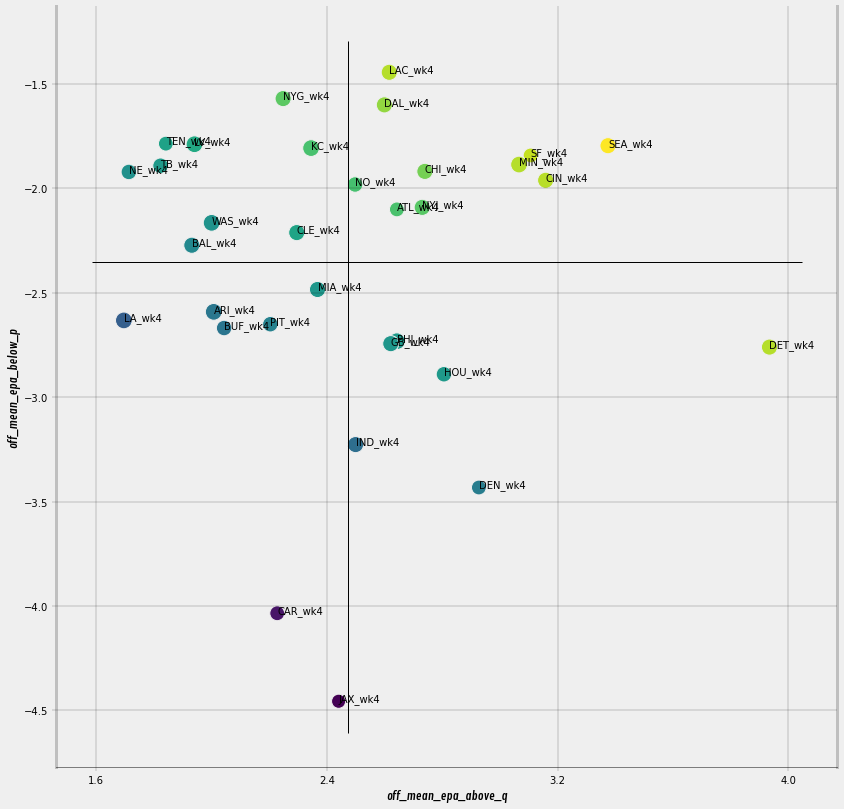

In [5]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

x_vals = 'off_mean_epa_above_q'
y_vals = 'off_mean_epa_below_p'

cmap = matplotlib.cm.get_cmap(color_map)
# norm = mpl.colors.SymLogNorm(linthresh=0.75, vmin=league_epa_min, vmax=league_epa_max)
# plot figure, axs
fig, ax = plt.subplots(figsize=(14,14))
fig.set_facecolor(background)
ax.set_facecolor(background)
#  set properties of axis
ax.patch.set_facecolor(background)
ax.grid(ls="-", lw=0.2, color=grid_color, zorder=-10)
ax.set_title("",pad=14,loc="left", color=axs_title_color, fontweight="light", fontfamily=axs_title_text, fontsize=18)
ax.set_xlabel(f"{x_vals}",color=axs_label_color,fontfamily=axs_label_text, fontsize=12)
ax.set_ylabel(f"{y_vals}",color=axs_label_color,fontfamily=axs_label_text, fontsize=12)
ax.tick_params(axis="both",length=4, width=0.2, color=grid_color)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

spines = ["top", "right", "bottom", "left"]
for s in spines:
    if s in ["top"]:
        ax.spines[s].set_visible(False)
    elif s in ["left", "right"]:
        ax.spines[s].set_color(spines_color)
        ax.spines[s].set_linewidth(3)
        ax.spines[s].set_alpha(.2)
    else:
        ax.spines[s].set_color(spines_color)
        ax.spines[s].set_alpha(.6)

weeks = [1,2,3,4,5,6,7]
weeks = [4]
# teams = ['KC','BUF']
# nfc_west = ['ARI','LA','SEA','SF']
df = kh.get_epa_info(df_pbp,weeks=weeks).reset_index()
ax.scatter(df[x_vals],df[y_vals], c=df[x_vals]+df[y_vals],cmap="viridis",edgecolors=background,s=100+(10*(df['off_qthpercentile_play_count']+df['off_pthpercentile_play_count'])), alpha=1,lw=1)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.hlines(y=df[y_vals].mean(),xmin=xmin, xmax=xmax, alpha=1,lw=1, color='k')
ax.vlines(x=df[x_vals].mean(),ymin=ymin, ymax=ymax, alpha=1,lw=1, color='k')
for row_idx, row in df.iterrows():
#     img = getImage(team=row.posteam)
#     img.thumbnail((32, 32))
#     imagebox = OffsetImage(img)
#     imagebox.image.axes = ax
#     ab = AnnotationBbox(imagebox, [row[x_vals],row[y_vals]], frameon=False)
#     ax.add_artist(ab)
    ax.annotate( (row.posteam +"_wk"+str(row.week)) , (row[x_vals],row[y_vals]))                

# ax.scatter(df['off_epa_mean'],df['off_epa_mean'], c=df['off_epa_mean']+df['off_epa_mean'],cmap="viridis",edgecolors=background,s=100+(10*(df['off_qthpercentile_play_count']+df['off_pthpercentile_play_count'])), alpha=1,lw=1)
# ax.scatter(df['off_epa_mean'],df['off_epa_mean'], c=df['off_epa_mean']+df['off_epa_mean'],cmap="viridis",edgecolors=background,s=100+(10*(df['off_qthpercentile_play_count']+df['off_pthpercentile_play_count'])), alpha=1,lw=1)

# ax.set_ylim(2.0,0.8)
plt.show()
            

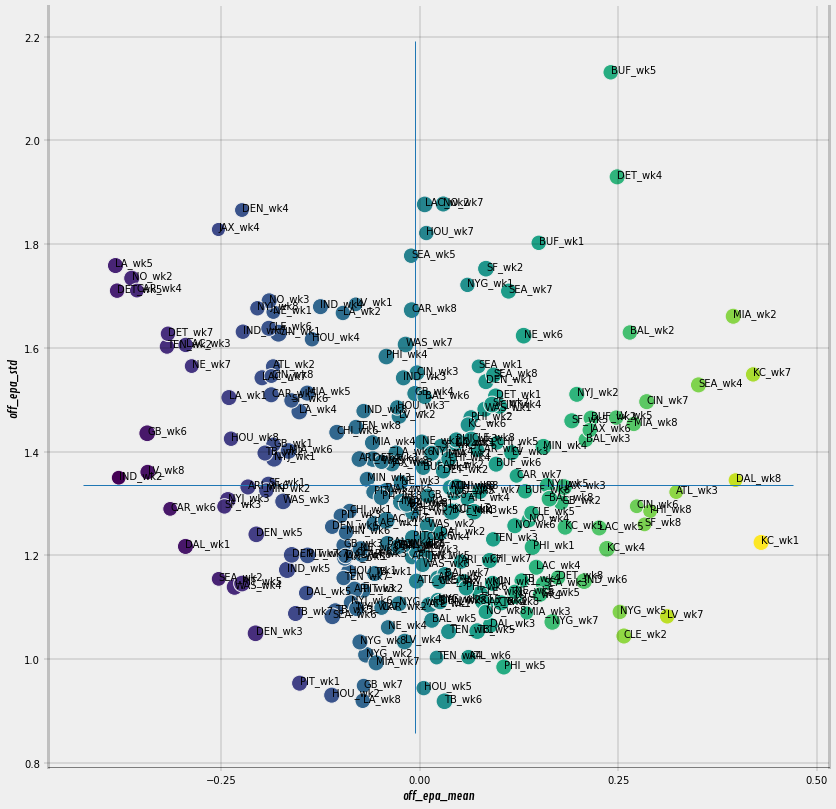

In [29]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

x_vals = 'off_epa_mean'
y_vals = 'off_epa_std'

cmap = matplotlib.cm.get_cmap(color_map)
# norm = mpl.colors.SymLogNorm(linthresh=0.75, vmin=league_epa_min, vmax=league_epa_max)
# plot figure, axs
fig, ax = plt.subplots(figsize=(14,14))
fig.set_facecolor(background)
ax.set_facecolor(background)
#  set properties of axis
ax.patch.set_facecolor(background)
ax.grid(ls="-", lw=0.2, color=grid_color, zorder=-10)
ax.set_title("",pad=14,loc="left", color=axs_title_color, fontweight="light", fontfamily=axs_title_text, fontsize=18)
ax.set_xlabel(f"{x_vals}",color=axs_label_color,fontfamily=axs_label_text, fontsize=12)
ax.set_ylabel(f"{y_vals}",color=axs_label_color,fontfamily=axs_label_text, fontsize=12)
ax.tick_params(axis="both",length=4, width=0.2, color=grid_color)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

spines = ["top", "right", "bottom", "left"]
for s in spines:
    if s in ["top"]:
        ax.spines[s].set_visible(False)
    elif s in ["left", "right"]:
        ax.spines[s].set_color(spines_color)
        ax.spines[s].set_linewidth(3)
        ax.spines[s].set_alpha(.2)
    else:
        ax.spines[s].set_color(spines_color)
        ax.spines[s].set_alpha(.6)

weeks = [1,2,3,4,5,6,7,8]
# weeks = [8]
# teams = ['KC','BUF']
# nfc_west = ['ARI','LA','SEA','SF']
df = kh.get_epa_info(df_pbp,weeks=weeks).reset_index()
ax.scatter(df[x_vals],df[y_vals], c=df[x_vals]/df[y_vals],cmap="viridis",edgecolors=background,s=100+(10*(df['off_qthpercentile_play_count']+df['off_pthpercentile_play_count'])), alpha=1,lw=1)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.hlines(y=df[y_vals].mean(),xmin=xmin, xmax=xmax, alpha=1,lw=1)
ax.vlines(x=df[x_vals].mean(),ymin=ymin, ymax=ymax, alpha=1,lw=1)
for row_idx, row in df.iterrows():
#     img = getImage(team=row.posteam)
#     img.thumbnail((32, 32))
#     imagebox = OffsetImage(img)
#     imagebox.image.axes = ax
#     ab = AnnotationBbox(imagebox, [row[x_vals],row[y_vals]], frameon=False)
#     ax.add_artist(ab)
    ax.annotate((row.posteam+"_wk"+str(row.week)), (row[x_vals],row[y_vals]))                

# ax.scatter(df['off_epa_mean'],df['off_epa_mean'], c=df['off_epa_mean']+df['off_epa_mean'],cmap="viridis",edgecolors=background,s=100+(10*(df['off_qthpercentile_play_count']+df['off_pthpercentile_play_count'])), alpha=1,lw=1)
# ax.scatter(df['off_epa_mean'],df['off_epa_mean'], c=df['off_epa_mean']+df['off_epa_mean'],cmap="viridis",edgecolors=background,s=100+(10*(df['off_qthpercentile_play_count']+df['off_pthpercentile_play_count'])), alpha=1,lw=1)

# ax.set_ylim(2.0,0.8)
plt.show()
            

    

In [31]:
df = df_pbp.merge(kh.get_epa_info(df=df_pbp), on=['game_id','posteam'])

In [32]:
# investigate the middle 80% of epa plays in the league
df

,game_id,play_id,epa,season_type,week,drive,series,down,ydstogo,yards_gained,...,off_epa_sum,off_epa_min,off_epa_max,off_epa_median,off_epa_mean,off_epa_std,off_mean_epa_above_q,off_mean_epa_below_p,off_qthpercentile_play_count,off_pthpercentile_play_count
0,2022_01_BAL_NYJ,43.0,-0.443521,REG,1,1.0,1.0,NaN,0.0,0.0,...,-16.901646,-6.817973,3.545995,-0.250196,-0.183714,1.386974,1.933903,-2.727187,10,10
1,2022_01_BAL_NYJ,68.0,1.468819,REG,1,1.0,1.0,1.0,10.0,19.0,...,-16.901646,-6.817973,3.545995,-0.250196,-0.183714,1.386974,1.933903,-2.727187,10,10
2,2022_01_BAL_NYJ,89.0,-0.492192,REG,1,1.0,2.0,1.0,10.0,0.0,...,-16.901646,-6.817973,3.545995,-0.250196,-0.183714,1.386974,1.933903,-2.727187,10,10
3,2022_01_BAL_NYJ,115.0,-0.325931,REG,1,1.0,2.0,2.0,10.0,5.0,...,-16.901646,-6.817973,3.545995,-0.250196,-0.183714,1.386974,1.933903,-2.727187,10,10
4,2022_01_BAL_NYJ,136.0,-2.402200,REG,1,1.0,2.0,3.0,5.0,0.0,...,-16.901646,-6.817973,3.545995,-0.250196,-0.183714,1.386974,1.933903,-2.727187,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20143,2022_08_WAS_IND,3360.0,0.792787,REG,8,22.0,50.0,2.0,6.0,9.0,...,-3.278491,-5.774215,4.127213,-0.072280,-0.048213,1.380576,2.408679,-2.594808,7,7
20144,2022_08_WAS_IND,3393.0,1.317872,REG,8,22.0,51.0,1.0,10.0,21.0,...,-3.278491,-5.774215,4.127213,-0.072280,-0.048213,1.380576,2.408679,-2.594808,7,7
20145,2022_08_WAS_IND,3417.0,3.138462,REG,8,22.0,52.0,1.0,10.0,33.0,...,-3.278491,-5.774215,4.127213,-0.072280,-0.048213,1.380576,2.408679,-2.594808,7,7
20146,2022_08_WAS_IND,3441.0,0.817806,REG,8,22.0,53.0,1.0,1.0,1.0,...,-3.278491,-5.774215,4.127213,-0.072280,-0.048213,1.380576,2.408679,-2.594808,7,7


64.0


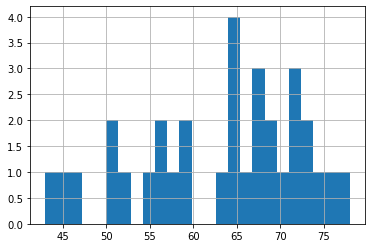

In [33]:
# teams' play count with EPAs in the league-wide's top 10th percentile of plays by EPA
(df[df.epa >= np.quantile(df.epa.dropna(), 0.9)]
 .groupby(['posteam'])
 .count()
 .epa
 .sort_values(ascending=False)
 .hist(bins=25)
)
print(df[df.epa >= np.quantile(df.epa.dropna(), 0.9)]
 .groupby(['posteam'])
 .count()
 .epa
 .sort_values(ascending=False).median()
)

posteam
DEN    77
IND    76
NYJ    75
PIT    74
ARI    73
DAL    69
NO     69
CHI    69
WAS    68
CIN    68
LAC    67
MIA    66
CAR    65
GB     64
NE     64
SF     63
DET    62
HOU    62
SEA    62
MIN    60
LA     60
JAX    59
CLE    59
TB     58
LV     57
BAL    57
ATL    56
NYG    56
BUF    54
PHI    52
TEN    48
KC     46
Name: epa, dtype: int64


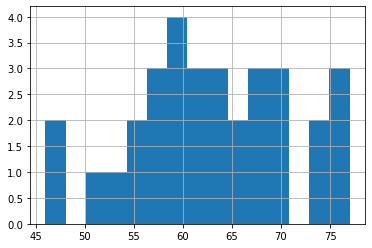

In [34]:
# teams' play count with EPAs in the league-wide's bottom 10th percentile of plays by EPA
(df[df.epa <= np.quantile(df.epa.dropna(), 0.1)]
 .groupby(['posteam'])
 .count()
 .epa
 .sort_values(ascending=False)
 .hist(bins=15)
)
print(df[df.epa <= np.quantile(df.epa.dropna(), 0.1)]
 .groupby(['posteam'])
 .count()
 .epa
 .sort_values(ascending=False)
)

In [44]:
# ratio of teams' play count per game with EPAs in the league-wide's bottom 10th percentile of plays by EPA
(((df[df.epa <= np.quantile(df.epa.dropna(), 0.1)]
 .groupby(['game_id','posteam'])
 .count()
 .epa
)/(df
      .groupby(['game_id','posteam'])
      .count()
      .epa
))
 .reset_index()
 .sort_values(by='epa')
)

,game_id,posteam,epa
232,2022_08_MIA_DET,DET,0.025316
48,2022_02_MIA_BAL,BAL,0.039474
238,2022_08_PIT_PHI,PHI,0.042254
143,2022_05_LAC_CLE,LAC,0.045977
219,2022_08_BAL_TB,TB,0.046512
...,...,...,...
58,2022_02_TB_NO,NO,0.178571
135,2022_05_DAL_LA,LA,0.188235
230,2022_08_LV_NO,LV,0.194444
30,2022_01_TB_DAL,DAL,0.195402


In [36]:
np.quantile(df.epa.dropna(), 0.1)

-1.1640367865562438

-9.96431 6.0020003
-9.96431 6.0020003


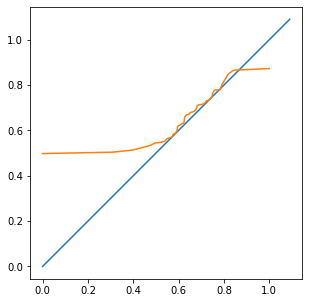

In [45]:
def normEPA_btwn0and1(df_alldrives, df_week):
    min_epa = df_alldrives.epa.min()
    max_epa = df_alldrives.epa.max()
    print(min_epa,max_epa)
    return (df_week.epa-min_epa) / (max_epa - min_epa)

team = 'SF'
week = 8
df_alldrives = kh.get_offensive_drives(df=df_pbp, teams=[team], weeks=[1,2,3,4,5,6,7])
df_week = kh.get_offensive_drives(df=df_pbp, teams=[team], weeks=[week])
df_notweek = kh.get_offensive_drives(df=df_pbp, teams=[team], weeks=[1,2,3,4,5,6])
week_epa_norm01 = normEPA_btwn0and1(df_alldrives, df_week)
notweek_epa_norm01 = normEPA_btwn0and1(df_alldrives, df_notweek)





fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')

x_vals, y_vals = [],[]
for x_quantile in np.arange(0.0,1.01,0.01):
    x=np.quantile(notweek_epa_norm01, x_quantile)
    y=np.quantile(week_epa_norm01, x_quantile)
    x_vals.append(x)
    y_vals.append(y)
    # print(x, y)
        
ax.plot(np.arange(0.0,1.1,0.01),np.arange(0.0,1.1,0.01))
ax.plot(x_vals,y_vals)


plt.show()

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fd8a53b2130>],
 'cmeans': <matplotlib.collections.LineCollection at 0x7fd8a53b2370>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fd8a53b2eb0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fd8a53b2a00>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fd8a53b8d90>}

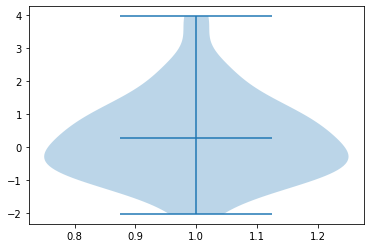

In [48]:
plt.violinplot(df_week.epa, showmeans=True,showextrema=True)

In [49]:
# develop week's per drive performance against league average? opponent's def average?
teams = ALL_TEAMS
weeks = ALL_WEEKS
df = kh.get_offensive_drives(df_pbp, teams=teams, weeks=weeks).merge((kh.get_offensive_drives(df_pbp, teams=teams, weeks=weeks)
 .groupby(['game_id','posteam','drive'])
 .agg({"epa":[('drive_play_count','count'),
              ('drive_epa_mean','mean'),
              ('drive_epa_median','median'),
              ('drive_epa_std','std')]})
 .droplevel(axis=1,level=0)
 .dropna(subset=["drive_epa_std"])
).reset_index(), on=['game_id','posteam','drive'])

In [103]:
df_rounded_epa = (df
 .loc[((df.posteam == team)&(df.week == week))]
 .assign(rounded_epa = np.round(df.epa,1))
 .groupby(['rounded_epa']).agg({"game_id":[("rounded_epa_count","count")]})
 .droplevel(axis=1,level=0)
 .reset_index()
)
df_rounded_epa
fig, ax = plt.subplots()
ax.hist(x='rounded_epa',bins=np.arange(min(df_rounded_epa.rounded_epa),max(df_rounded_epa.rounded_epa +0.1),0.1),weights='rounded_epa_count',data=df_rounded_epa,)
# , bins=range(min(rounded_epa),max(rounded_epa),0.1))
plt.show()

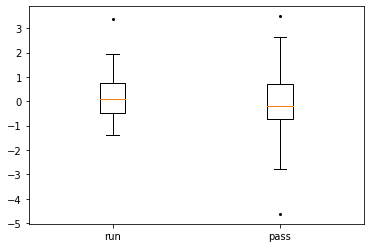

In [160]:
team = 'BUF'
week = 8
df_team_week = \
(df
 .loc[((df.posteam == team)&(df.week == week))]
)

data = [df_team_week[df_team_week['play_type']=='run'].epa, df_team_week[df_team_week['play_type']=='pass'].epa]
data
pos= np.arange(len(data))+1

fig, ax = plt.subplots()
bp = ax.boxplot(data, sym="k", positions=pos)
ax.set_xticklabels(['run','pass'])
ax.set_xlim(0.5,2+0.5)
plt.setp(bp['whiskers'], color='k', linestyle='-')
plt.setp(bp['fliers'], markersize=2.0)
plt.show()

In [150]:
## KMeans Cluster epa values for week?
## Are there clusters of epa valued plays that give us any insight into the performance of a team? explosives? methodical (successful or bad)? feast or famine?
# sum_sq_dists =[]
# clusters = range(1,10)
# for k in clusters:
#     kmeans = KMeans(n_clusters=k, random_state=36)
#     kmeans.fit(df_teamEPA[df_teamEPA.posteam == 'SF'].epa.values.reshape(-1,1))
#     sum_sq_dists.append(kmeans.inertia_)
    
# plt.plot(clusters, sum_sq_dists, 'bx-')
# plt.xlabel("values of k")
# plt.ylabel('sum of squares distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()
# kmeans = KMeans(n_clusters=3, random_state=36)
# kmeans.fit(df_teamEPA[df_teamEPA.posteam == 'SF'].epa.values.reshape(-1,1))
# print(f"kmeans labels: {kmeans.labels_}")
# print(f"kmeans cluster centers: {kmeans.cluster_centers_}")

In [19]:
df

,game_id,play_id,epa,season_type,week,drive,series,down,ydstogo,yards_gained,...,fixed_drive_result,play_type,penalty_team,penalty_type,penalty_yards,season,drive_play_count,drive_epa_mean,drive_epa_median,drive_epa_std
0,2022_01_BAL_NYJ,68.0,1.468819,REG,1,1.0,1.0,1.0,10.0,19.0,...,Punt,run,None,None,NaN,2022,5,-0.396627,-0.325931,1.373278
1,2022_01_BAL_NYJ,89.0,-0.492192,REG,1,1.0,2.0,1.0,10.0,0.0,...,Punt,pass,None,None,NaN,2022,5,-0.396627,-0.325931,1.373278
2,2022_01_BAL_NYJ,115.0,-0.325931,REG,1,1.0,2.0,2.0,10.0,5.0,...,Punt,run,None,None,NaN,2022,5,-0.396627,-0.325931,1.373278
3,2022_01_BAL_NYJ,136.0,-2.402200,REG,1,1.0,2.0,3.0,5.0,0.0,...,Punt,pass,NYJ,Intentional Grounding,10.0,2022,5,-0.396627,-0.325931,1.373278
4,2022_01_BAL_NYJ,172.0,-0.231632,REG,1,1.0,2.0,4.0,15.0,0.0,...,Punt,punt,None,None,NaN,2022,5,-0.396627,-0.325931,1.373278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17937,2022_08_WAS_IND,3417.0,3.138462,REG,8,22.0,52.0,1.0,10.0,33.0,...,Touchdown,pass,None,None,NaN,2022,9,0.727820,0.792787,1.261756
17938,2022_08_WAS_IND,3441.0,0.817806,REG,8,22.0,53.0,1.0,1.0,1.0,...,Touchdown,run,None,None,NaN,2022,9,0.727820,0.792787,1.261756
17939,2022_08_WAS_IND,3501.0,-0.177054,REG,8,23.0,54.0,1.0,10.0,0.0,...,End of half,pass,None,None,NaN,2022,3,-0.094917,-0.094950,0.082153
17940,2022_08_WAS_IND,3535.0,-0.012748,REG,8,23.0,54.0,2.0,10.0,8.0,...,End of half,pass,None,None,NaN,2022,3,-0.094917,-0.094950,0.082153
